# Taller 04: Deteccion de Objetos

* María Sofía Uribe
* Javier Daza Olivella


In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Visualizamos el formato de las annotaciones


In [ ]:
mat_data = scipy.io.loadmat('./caltech-101/Annotations/ant/annotation_0001.mat')
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Dec 15 09:52:03 2004',
 '__version__': '1.0',
 '__globals__': [],
 'box_coord': array([[ 19, 189,  25, 262]], dtype=uint16),
 'obj_contour': array([[ 41.35,  36.55,  44.05,  62.05,  86.35,  98.35, 112.45, 117.85,
         120.55, 122.65, 138.85, 146.05, 154.75, 169.45, 196.15, 208.15,
         210.55, 224.35, 230.05, 232.75, 218.65, 209.35, 203.65, 198.25,
         203.95, 203.95, 197.95, 199.45, 190.15, 186.55, 183.25, 183.25,
         187.15, 192.85, 183.25, 176.95, 179.35, 183.85, 170.95, 156.85,
         157.75, 150.25, 142.15, 140.95, 137.05, 140.05, 131.65, 122.65,
         118.75, 133.75, 130.75, 125.95, 128.05, 130.75, 119.35, 102.55,
          78.55,  58.15,  46.45,  23.65,   2.65,   2.65,  23.65,  41.65,
          41.65,  41.65],
        [ 98.15,  77.15,  48.65,  23.15,  11.75,  11.75,  38.75,  14.15,
          21.95,  30.05,   9.35,   9.35,   2.15,   5.75,  13.55,  24.05,
          47.15,  49.55,  59.15, 

## Hacemos un preview de una imagen, en este caso, airplanes, y visualizamos sus anotaciones


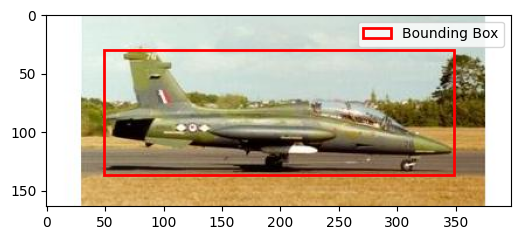

In [ ]:
image_path = "./caltech-101/101_ObjectCategories/airplanes/image_0001.jpg"
mat_path = "./caltech-101/Annotations/airplanes/annotation_0001.mat"

image = Image.open(image_path)

data = scipy.io.loadmat(mat_path)

box = data['box_coord'][0] 


y1, y2, x1, x2 = box
x, y = x1, y1
w, h = x2 - x1, y2 - y1


fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)


rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none', label='Bounding Box')
ax.add_patch(rect)


ax.legend()
plt.show()


In [4]:
# Contruimos nuestro Dataset, donde parametrizamos el uso de los labels para cada imagen
# Este paso es crucial, por que es donde definimos como se seleccionara cada imagen y su respectiva annotacion con los bounding boxes
# Adicionalmente seteamos un parametro split, que sera el encargado de generar Train(70%), val(15%) y test(15%)

class Caltech101BBoxDataset(Dataset):
    def __init__(self, base_path='caltech-101', transform=None, split='train', train_ratio=0.7, val_ratio=0.15):

        self.transform = transform
        self.data_list = []
        
        annotations_dir = os.path.join(base_path, 'Annotations')
        images_dir = os.path.join(base_path, '101_ObjectCategories')
        
        for category in os.listdir(annotations_dir):
            category_ann_path = os.path.join(annotations_dir, category)
            
            if not os.path.isdir(category_ann_path):
                continue
            
            for ann_file in os.listdir(category_ann_path):
                if not ann_file.endswith('.mat'):
                    continue
                
                mat_path = os.path.join(category_ann_path, ann_file)
                
                try:
                    mat_data = scipy.io.loadmat(mat_path)
                    

                    if 'box_coord' in mat_data:
                        y1, y2, x1, x2 = mat_data['box_coord'].flatten().astype(float)
                        xmin, ymin, xmax, ymax = x1, y1, x2, y2
                    
                    elif 'obj_contour' in mat_data:
                        contour = mat_data['obj_contour']
                        if contour.shape[1] > 0:
                            x_coords = contour[0, :]
                            y_coords = contour[1, :]
                            xmin = float(np.min(x_coords))
                            ymin = float(np.min(y_coords))
                            xmax = float(np.max(x_coords))
                            ymax = float(np.max(y_coords))
                        else:
                            continue
                    else:
                        continue
                    

                    img_name = ann_file.replace('annotation_', 'image_').replace('.mat', '.jpg')
                    img_path = os.path.join(images_dir, category, img_name)
                    
                    if not os.path.exists(img_path):
                        continue
                    
                    with Image.open(img_path) as img:
                        width, height = img.size
                    
                    self.data_list.append({
                        'image_path': img_path,
                        'category': category,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax,
                        'width': width,
                        'height': height
                    })
                
                except Exception as e:
                    continue
        
        print(f"Total imágenes cargadas: {len(self.data_list)}")
        
        # --- dividir en train/val/test ---
        np.random.seed(42)
        indices = np.random.permutation(len(self.data_list))
        
        n_train = int(len(self.data_list) * train_ratio)
        n_val = int(len(self.data_list) * val_ratio)
        
        if split == 'train':
            indices = indices[:n_train]
        elif split == 'val':
            indices = indices[n_train:n_train+n_val]
        else:
            indices = indices[n_train+n_val:]
        
        self.data_list = [self.data_list[i] for i in indices]
        print(f"Split {split}: {len(self.data_list)} imágenes")
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        
        image = Image.open(item['image_path']).convert('RGB')
        
        # --- normalizar bbox a [0, 1] ---
        bbox = torch.tensor([
            item['xmin'] / item['width'],
            item['ymin'] / item['height'],
            item['xmax'] / item['width'],
            item['ymax'] / item['height']
        ], dtype=torch.float32)
        
        bbox = torch.clamp(bbox, 0.0, 1.0)
        
        if self.transform:
            image = self.transform(image)
        
        return image, bbox

### Construimos nuestro modelo

- Usaremos el modelo resnet50 pre entrenado

- descartamos ultima capa de clasificacion (imagenet: 1000 clases)

-- con nn.Identity() ignoramos esa capa, nos quedamos con la capa de features, y construimos nuestra propia capa Sequential, que incorpora

- Capa lineal, con bottle neck 256

- Relu

- Dropout 50%  [para evitar sobreajuste]

- Capa lineal, con bottle neck 128

- Relu

- Dropout 30%  [para evitar sobreajuste]

- y finalmente la capa lineal final con 4 salidas (bounding boxes)

En el forward, incluimos la normalizacion 0,1, usando la funcion sigmoide.

In [ ]:


class BBoxRegressor(nn.Module):
    def __init__(self, pretrained=True):
        super(BBoxRegressor, self).__init__()
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained)
        

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        # Regressor para bounding box
        self.regressor = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)  # [x_min, y_min, x_max, y_max]
        )
    
    def forward(self, x):
        features = self.resnet(x)
        bbox = self.regressor(features)
        bbox = torch.sigmoid(bbox)  # Normalizar a [0, 1]
        return bbox


In [6]:
# Definimos nuestra funcion de entrenamiento de 1 epoch

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, bboxes in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        bboxes = bboxes.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, bboxes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(dataloader)


# Funcion de evaluacion del modelo, donde incluimos el calculo de IOU
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    
    with torch.no_grad():
        for images, bboxes in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            bboxes = bboxes.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            running_loss += loss.item()
            
            # Calcular IoU
            iou = calculate_iou(outputs, bboxes)
            total_iou += iou.mean().item()
    
    avg_loss = running_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_loss, avg_iou


# Funcion helper para el calculo del IOU
def calculate_iou(pred_boxes, true_boxes):
    """Intersection over Union"""
    x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])
    
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    
    area_pred = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    area_true = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
    
    union = area_pred + area_true - intersection
    iou = intersection / (union + 1e-6)
    
    return iou


In [7]:
# Iniciamos los parametros del entrenamiento y creamos los dataloders


BASE_PATH = 'caltech-101'
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = Caltech101BBoxDataset(BASE_PATH, transform=transform, split='train')
val_dataset = Caltech101BBoxDataset(BASE_PATH, transform=transform, split='val')
test_dataset = Caltech101BBoxDataset(BASE_PATH, transform=transform, split='test')

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)

Device: cuda



Total imágenes cargadas: 7444
Split train: 5210 imágenes
Total imágenes cargadas: 7444
Split val: 1116 imágenes
Total imágenes cargadas: 7444
Split test: 1118 imágenes


In [8]:
# Modelo
model = BBoxRegressor(pretrained=True).to(device)

# Loss y Optimizer
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
best_iou = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = evaluate(model, val_loader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    
    scheduler.step(val_loss)
    
    # Guardar mejor modelo
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_bbox_model.pth')
        print(f"Mejor modelo guardado (IoU: {best_iou:.4f})")




Epoch 1/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.98it/s]


Train Loss: 0.0126
Val Loss: 0.0037 | Val IoU: 0.7482
Mejor modelo guardado (IoU: 0.7482)

Epoch 2/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


Train Loss: 0.0040
Val Loss: 0.0028 | Val IoU: 0.7612
Mejor modelo guardado (IoU: 0.7612)

Epoch 3/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.08it/s]


Train Loss: 0.0033
Val Loss: 0.0027 | Val IoU: 0.7717
Mejor modelo guardado (IoU: 0.7717)

Epoch 4/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.08it/s]


Train Loss: 0.0028
Val Loss: 0.0023 | Val IoU: 0.7865
Mejor modelo guardado (IoU: 0.7865)

Epoch 5/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.06it/s]


Train Loss: 0.0024
Val Loss: 0.0019 | Val IoU: 0.7979
Mejor modelo guardado (IoU: 0.7979)

Epoch 6/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


Train Loss: 0.0020
Val Loss: 0.0017 | Val IoU: 0.8123
Mejor modelo guardado (IoU: 0.8123)

Epoch 7/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.99it/s]


Train Loss: 0.0018
Val Loss: 0.0017 | Val IoU: 0.8117

Epoch 8/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s]


Train Loss: 0.0016
Val Loss: 0.0017 | Val IoU: 0.8213
Mejor modelo guardado (IoU: 0.8213)

Epoch 9/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.11it/s]


Train Loss: 0.0015
Val Loss: 0.0016 | Val IoU: 0.8261
Mejor modelo guardado (IoU: 0.8261)

Epoch 10/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s]


Train Loss: 0.0014
Val Loss: 0.0014 | Val IoU: 0.8323
Mejor modelo guardado (IoU: 0.8323)

Epoch 11/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


Train Loss: 0.0013
Val Loss: 0.0014 | Val IoU: 0.8355
Mejor modelo guardado (IoU: 0.8355)

Epoch 12/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


Train Loss: 0.0012
Val Loss: 0.0014 | Val IoU: 0.8336

Epoch 13/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.90it/s]


Train Loss: 0.0012
Val Loss: 0.0014 | Val IoU: 0.8409
Mejor modelo guardado (IoU: 0.8409)

Epoch 14/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]


Train Loss: 0.0011
Val Loss: 0.0013 | Val IoU: 0.8424
Mejor modelo guardado (IoU: 0.8424)

Epoch 15/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.60it/s]


Train Loss: 0.0011
Val Loss: 0.0013 | Val IoU: 0.8447
Mejor modelo guardado (IoU: 0.8447)

Epoch 16/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.10it/s]


Train Loss: 0.0011
Val Loss: 0.0013 | Val IoU: 0.8475
Mejor modelo guardado (IoU: 0.8475)

Epoch 17/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Train Loss: 0.0010
Val Loss: 0.0013 | Val IoU: 0.8495
Mejor modelo guardado (IoU: 0.8495)

Epoch 18/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]


Train Loss: 0.0010
Val Loss: 0.0013 | Val IoU: 0.8471

Epoch 19/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


Train Loss: 0.0010
Val Loss: 0.0012 | Val IoU: 0.8490

Epoch 20/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.55it/s]


Train Loss: 0.0009
Val Loss: 0.0013 | Val IoU: 0.8469

Epoch 21/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.06it/s]


Train Loss: 0.0010
Val Loss: 0.0013 | Val IoU: 0.8501
Mejor modelo guardado (IoU: 0.8501)

Epoch 22/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.09it/s]


Train Loss: 0.0009
Val Loss: 0.0013 | Val IoU: 0.8522
Mejor modelo guardado (IoU: 0.8522)

Epoch 23/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.10it/s]


Train Loss: 0.0009
Val Loss: 0.0012 | Val IoU: 0.8524
Mejor modelo guardado (IoU: 0.8524)

Epoch 24/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


Train Loss: 0.0009
Val Loss: 0.0012 | Val IoU: 0.8550
Mejor modelo guardado (IoU: 0.8550)

Epoch 25/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.61it/s]


Train Loss: 0.0008
Val Loss: 0.0012 | Val IoU: 0.8532

Epoch 26/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.12it/s]


Train Loss: 0.0009
Val Loss: 0.0012 | Val IoU: 0.8572
Mejor modelo guardado (IoU: 0.8572)

Epoch 27/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]


Train Loss: 0.0008
Val Loss: 0.0012 | Val IoU: 0.8553

Epoch 28/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]


Train Loss: 0.0008
Val Loss: 0.0012 | Val IoU: 0.8599
Mejor modelo guardado (IoU: 0.8599)

Epoch 29/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


Train Loss: 0.0008
Val Loss: 0.0011 | Val IoU: 0.8631
Mejor modelo guardado (IoU: 0.8631)

Epoch 30/30


Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]


Train Loss: 0.0007
Val Loss: 0.0011 | Val IoU: 0.8632
Mejor modelo guardado (IoU: 0.8632)


In [10]:

print("\n=== Test Fnal ===")
model.load_state_dict(torch.load('best_bbox_model.pth'))
test_loss, test_iou = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test IoU: {test_iou:.4f}")


=== Test Fnal ===


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]

Test Loss: 0.0012 | Test IoU: 0.8615


### Resultados: Test

- IOU: 86%
- Loss: 0.0012

In [16]:
# Funciones para visualizar las predicciones y denormalizar los bounding boxes, ya que la salida del modelo nos los da normalizados.

def denormalize_bbox(bbox, width, height):
    """Convierte bbox normalizado [0,1] → coordenadas reales"""
    x_min, y_min, x_max, y_max = bbox
    return [
        int(x_min * width),
        int(y_min * height),
        int(x_max * width),
        int(y_max * height)
    ]

def visualize_predictions(model, dataloader, device = 'cuda', num_images=10):
    model.eval()
    images_shown = 0
    
    with torch.no_grad():
        for images, bboxes in dataloader:
            images = images.to(device)
            preds = model(images).cpu().numpy()
            images = images.cpu()

            for i in range(images.size(0)):
                img = images[i].permute(1, 2, 0).numpy()
                img = np.clip(img, 0, 1)

                pred_bbox = denormalize_bbox(preds[i], img.shape[1], img.shape[0])
                true_bbox = denormalize_bbox(bboxes[i].numpy(), img.shape[1], img.shape[0])

                fig, ax = plt.subplots(figsize=(5, 5))
                ax.imshow(img)

                rect_pred = plt.Rectangle((pred_bbox[0], pred_bbox[1]),
                                          pred_bbox[2]-pred_bbox[0],
                                          pred_bbox[3]-pred_bbox[1],
                                          linewidth=2, edgecolor='r', facecolor='none', label='Predicción')
                rect_true = plt.Rectangle((true_bbox[0], true_bbox[1]),
                                          true_bbox[2]-true_bbox[0],
                                          true_bbox[3]-true_bbox[1],
                                          linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
                ax.add_patch(rect_pred)
                ax.add_patch(rect_true)
                ax.legend()
                ax.set_title("Rojo: Predicción | Verde: Ground Truth")
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return


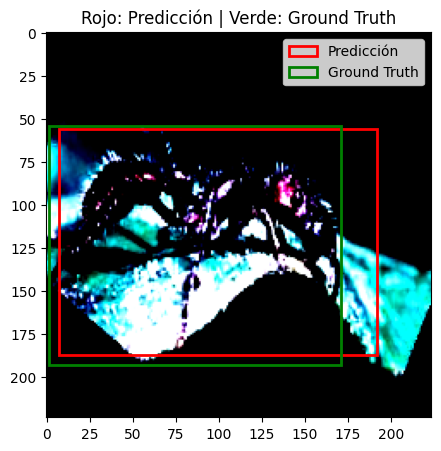

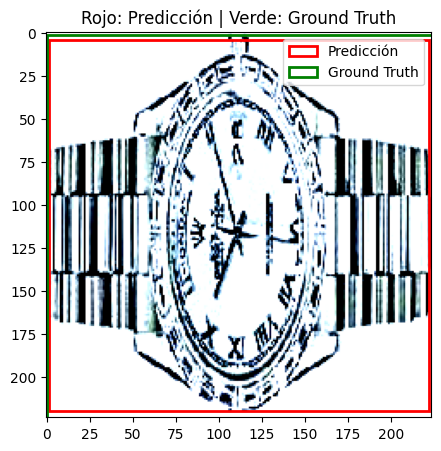

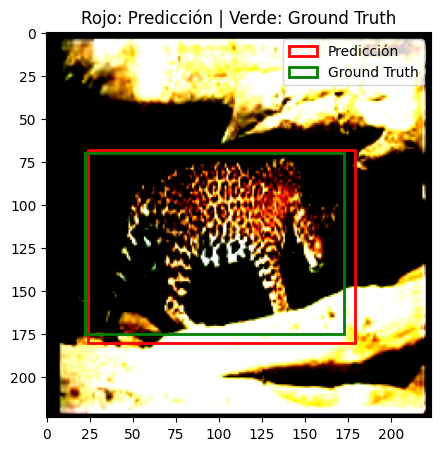

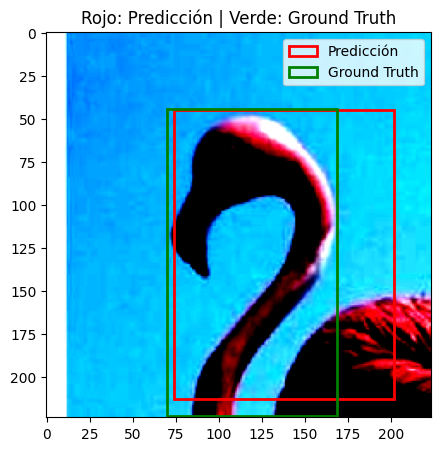

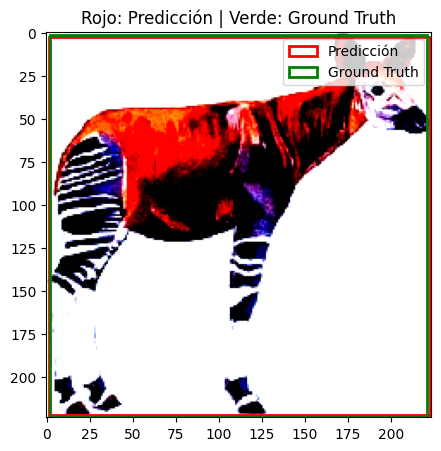

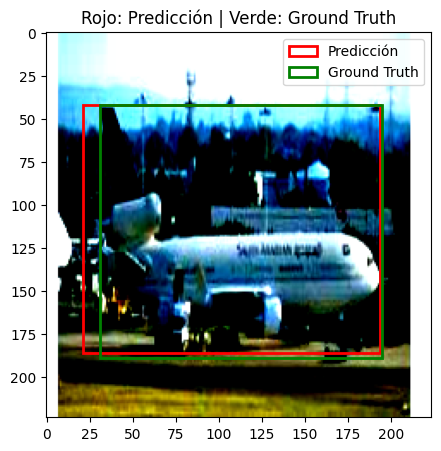

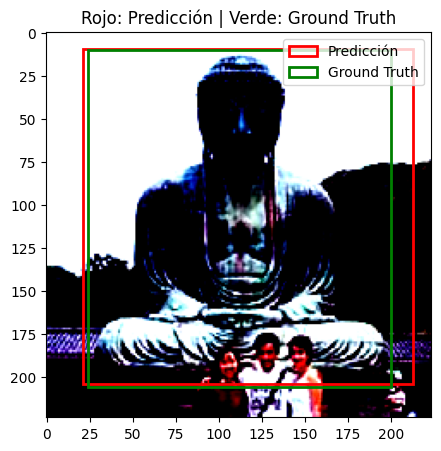

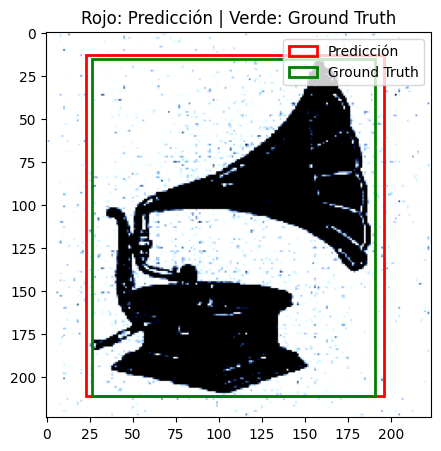

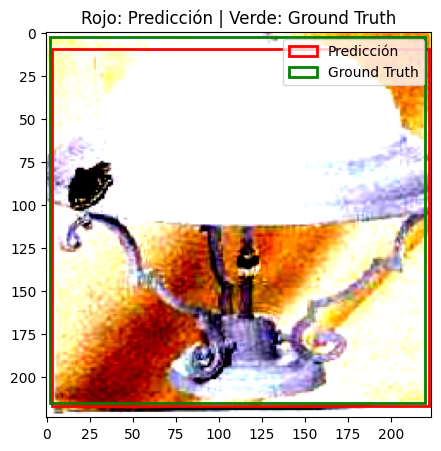

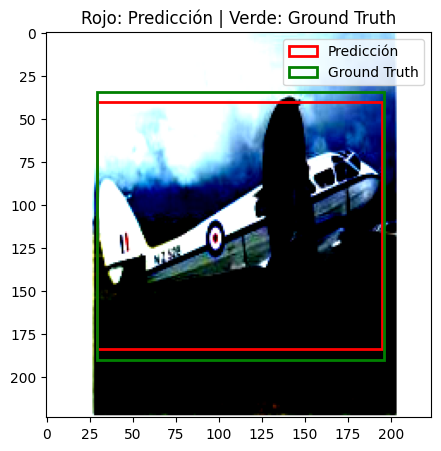

In [17]:
visualize_predictions(model, test_loader)